In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


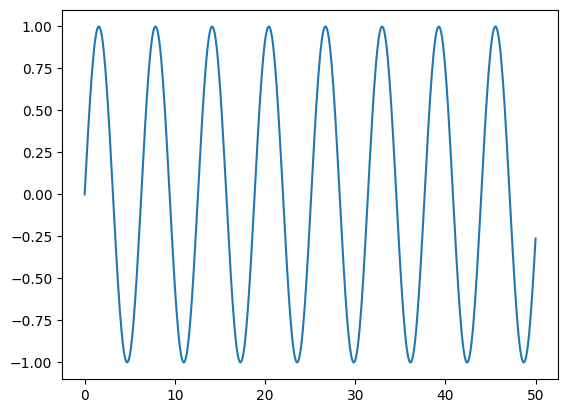

In [2]:
x= np.linspace(0,50,501)
y= np.sin(x)
plt.plot(x,y)

forming a DF of x and y

In [3]:
df= pd.DataFrame(data=y, index=x, columns=['sine'])

In [4]:
df

,sine
0.0,0.000000
0.1,0.099833
0.2,0.198669
0.3,0.295520
0.4,0.389418
...,...
49.6,-0.617439
49.7,-0.535823
49.8,-0.448854
49.9,-0.357400


In [5]:
len(df)

501

we need to split the df into training and testing sets, but unlike previous versions, we won't use train test split instead we'll use
indexing to split

In [6]:
#if we want 10% of our df to be testing set
test_percent=0.1
test_point= np.round(test_percent*len(df))
test_point

50.0

In [8]:
test_ind= int(len(df)-test_point)
test_ind

451

In [9]:
train = df.iloc[:test_ind]
test= df.iloc[test_ind:]

next step is to scale/normalize our target column, we don't that in other deep learning algorithms

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

next step is to form batches of dataset using TimeseriesGenerator

In [11]:
from tensorflow import keras
from keras.preprocessing.sequence import TimeseriesGenerator

help(TimeseriesGenerator)

Help on class TimeseriesGenerator in module keras.preprocessing.sequence:

class TimeseriesGenerator(keras.utils.data_utils.Sequence)
 |  TimeseriesGenerator(data, targets, length, sampling_rate=1, stride=1, start_index=0, end_index=None, shuffle=False, reverse=False, batch_size=128)
 |  
 |  Utility class for generating batches of temporal data.
 |  
 |  Deprecated: `tf.keras.preprocessing.sequence.TimeseriesGenerator` does not
 |  operate on tensors and is not recommended for new code. Prefer using a
 |  `tf.data.Dataset` which provides a more efficient and flexible mechanism for
 |  batching, shuffling, and windowing input. See the
 |  [tf.data guide](https://www.tensorflow.org/guide/data) for more details.
 |  
 |  This class takes in a sequence of data-points gathered at
 |  equal intervals, along with time series parameters such as
 |  stride, length of history, etc., to produce batches for
 |  training/validation.
 |  
 |  Arguments:
 |      data: Indexable generator (such as li

In [12]:
length= 50
batch_size=1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)

now we form the network

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, SimpleRNN
n_features =1

model= Sequential()
model.add(SimpleRNN(units=50, input_shape=((length,n_features))))   # units and input_shape are imp params

model.add(Dense(units=1))
model.compile(loss='mse', optimizer='adam')

In [14]:
model.fit_generator(generator=generator, epochs=5) #you can add early stopping

C:\Users\dell\AppData\Local\Temp\ipykernel_1260\3374017531.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=generator, epochs=5) #you can add early stopping


Epoch 1/5
401/401 [==============================] - 9s 15ms/step - loss: 0.0059
Epoch 2/5
401/401 [==============================] - 5s 13ms/step - loss: 1.2591e-04
Epoch 3/5
401/401 [==============================] - 6s 14ms/step - loss: 1.2152e-04
Epoch 4/5
401/401 [==============================] - 6s 15ms/step - loss: 2.2750e-04
Epoch 5/5
401/401 [==============================] - 5s 13ms/step - loss: 6.4353e-05


the evaluation of RNN is very different from the rest of DL algorithms, as we have trained the generator in batches so 
we'll predict in batches

In [17]:
#first we'll evaluate the first batch
first_eval_batch = scaled_train[-length:]
first_eval_batch = first_eval_batch.reshape((1, length, n_features))
model.predict(first_eval_batch)[0]

1/1 [==============================] - 0s 43ms/step


array([0.9529931], dtype=float32)

In [16]:
scaled_test[0]

array([0.94955134])

In [18]:
#now we apply for loop
test_predictions = []
first_eval_batch= scaled_train[-length:]
current_batch= first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    current_pred= model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch= np.append(current_batch[:,1:,:], [[current_pred]], axis=1) #if axis is not provided, then the values are flattened before appending
    


1/1 [==============================] - 0s 38ms/step


In [19]:
#test_predictions are predictions of our model but they're scaled, for comparision with test, we need to reverse the transformation
true_preds= scaler.inverse_transform(test_predictions)

In [20]:
test['Predictions']= true_preds

C:\Users\dell\AppData\Local\Temp\ipykernel_1260\2268266237.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions']= true_preds


<AxesSubplot: >

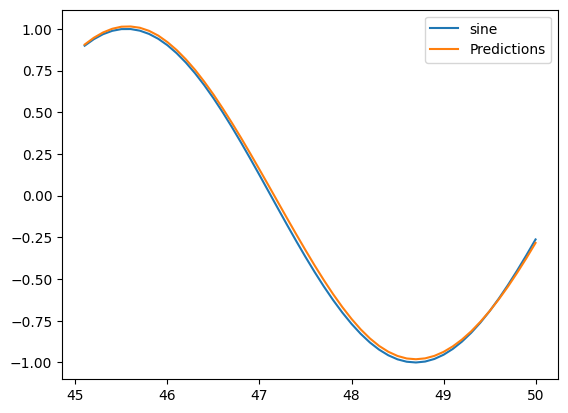

In [23]:
test[['sine', 'Predictions']].plot()

In [22]:
test.columns

Index(['sine', 'Predictions'], dtype='object')